# Testes - Temperatura

Una vez que los datos son alistados, se realiza el análisis de testes. 

Para temperatura, se consideran los siguientes testes:

- Test de rango fijo
- Tests de consistencia interna
- Test de ceros
- Test para el salto térmico diario
- Tests de rango dinámico, consistencia temporal, persistencia y coherencia espacial

In [16]:
import pandas as pd
import numpy as np
import os
import re
from functools import reduce
%matplotlib inline

In [17]:
PATH_DADOS = '../dados/'
NOMBRE_ESTACION = 'CHUCURI'
FILE_DATOS_PROCESADOS = NOMBRE_ESTACION.lower() + '_procesado.csv'
FILE_DATOS_TESTADOS = NOMBRE_ESTACION.lower() + '_testado_temp.csv'

In [18]:
365*24*6*7

367920

In [19]:
df = pd.read_csv(PATH_DADOS + FILE_DATOS_PROCESADOS, 
                 sep = ';', 
                 parse_dates = ["FECHA"],
                 date_parser = lambda col: pd.to_datetime(col)
                )

dfTemp = df[['FECHA', 'TEMP']].copy()
dfTemp = dfTemp.sort_values(by=['FECHA']).reset_index(drop = True)
dfTemp

,FECHA,TEMP
0,2011-01-01 01:00:00-05:00,20.6
1,2011-01-01 02:00:00-05:00,20.4
2,2011-01-01 03:00:00-05:00,20.2
3,2011-01-01 04:00:00-05:00,19.4
4,2011-01-01 05:00:00-05:00,19.2
...,...,...
50278,2017-12-31 19:00:00-05:00,20.7
50279,2017-12-31 20:00:00-05:00,20.5
50280,2017-12-31 21:00:00-05:00,20.4
50281,2017-12-31 22:00:00-05:00,20.8


## Test de rango fijo

In [20]:
t_max = 50.
t_min = 15.
lamb_func = lambda r: np.nan if ((r > t_max) | (r < t_min)) else r
dfTemp['TEMP_RANGO_FIJO'] = dfTemp['TEMP'].apply(lamb_func)
dfTemp

,FECHA,TEMP,TEMP_RANGO_FIJO
0,2011-01-01 01:00:00-05:00,20.6,20.6
1,2011-01-01 02:00:00-05:00,20.4,20.4
2,2011-01-01 03:00:00-05:00,20.2,20.2
3,2011-01-01 04:00:00-05:00,19.4,19.4
4,2011-01-01 05:00:00-05:00,19.2,19.2
...,...,...,...
50278,2017-12-31 19:00:00-05:00,20.7,20.7
50279,2017-12-31 20:00:00-05:00,20.5,20.5
50280,2017-12-31 21:00:00-05:00,20.4,20.4
50281,2017-12-31 22:00:00-05:00,20.8,20.8


<AxesSubplot:xlabel='FECHA', ylabel='TEMP_RANGO_FIJO'>

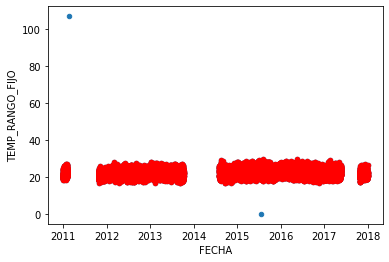

In [21]:
ax = dfTemp.plot(kind = 'scatter', x='FECHA', y='TEMP')
dfTemp.plot(kind = 'scatter', x='FECHA', y='TEMP_RANGO_FIJO', ax=ax, color='red')

In [62]:
dfTemp['FECHA_DIA'] = dfTemp['FECHA'].dt.date
dfAux = (dfTemp.groupby('FECHA_DIA')
       .agg({'TEMP_RANGO_FIJO': ['mean', 'min', 'max']})
       .reset_index(level = [0])
#        .set_index('TEMP_RANGO_FIJO')
)
dfAux = (dfAux.sort_values(by = 'FECHA_DIA'))
dfAux['TEMP_MAX_D_1'] = (dfAux[('TEMP_RANGO_FIJO', 'max')].shift(1))
dfAux['TEMP_MIN_D_1'] = (dfAux[('TEMP_RANGO_FIJO', 'min')].shift(1))

dfCons = (pd.merge(dfTemp,dfAux,on='FECHA_DIA', how='outer')
            .rename(columns = {('TEMP_RANGO_FIJO', 'mean') : 'TEMP_PROM_DIARIA',
                                 ('TEMP_RANGO_FIJO', 'min') : 'TEMP_MIN_DIARIA',
                                 ('TEMP_RANGO_FIJO', 'max') : 'TEMP_MAX_DIARIA',
                                 ('TEMP_MAX_D_1', ''): 'TEMP_MAX_D_1',
                              ('TEMP_MIN_D_1', ''): 'TEMP_MIN_D_1',})
        )
dfCons['FECHA_DIA'] = dfCons['FECHA_DIA'].apply(lambda x: x.strftime('%Y-%m-%d'))
dfCons['TEMP_SH_2'] = (dfCons['TEMP'].shift(1))
dfCons['TEMP_SH_4'] = (dfCons['TEMP'].shift(2))
dfCons['TEMP_SH_6'] = (dfCons['TEMP'].shift(3))

dfCons['FORM_2_30'] = np.where((dfCons['TEMP_MAX_DIARIA'] > dfCons['TEMP_PROM_DIARIA']) 
                                    & (dfCons['TEMP_MIN_DIARIA'] < dfCons['TEMP_PROM_DIARIA']), 1, 0)

ant_null_act_notnull = lambda df, t_act, t_ant: ~df[t_act].isnull() & df[t_ant].isnull()
ant_notnull_act_notnull = lambda df, t_act, t_ant: ~df[t_act].isnull() & ~df[t_ant].isnull()

dfCons['FORM_2_33'] = np.where( (dfCons['FORM_2_30'] == 1) & ((ant_null_act_notnull(dfCons, 'TEMP_MAX_DIARIA', 'TEMP_MIN_D_1')) | (dfCons['TEMP_MAX_DIARIA'] > dfCons['TEMP_MIN_D_1'])), 1, 0)
dfCons['FORM_2_34'] = np.where( (dfCons['FORM_2_33'] == 1) & ((ant_null_act_notnull(dfCons, 'TEMP_MIN_DIARIA', 'TEMP_MAX_D_1')) | (dfCons['TEMP_MIN_DIARIA'] <= dfCons['TEMP_MAX_D_1'])), 1, 0)
dfCons['FORM_2_35'] = np.where( (dfCons['FORM_2_34'] == 1) & (dfCons['TEMP_MAX_DIARIA'] - dfCons['TEMP_MIN_DIARIA'] < 23.8), 1, 0)
# Ecuación 2.36 --> Si ya tenemos los valores dentro de un rango, para que verificar si tengo tres dias seguidos con t min = 0?

dfCons['FORM_2_37'] = (np.where((dfCons['FORM_2_35'] == 1) & 
                                ((ant_null_act_notnull(dfCons, 'TEMP', 'TEMP_SH_2')) | 
                                 (((~dfCons['TEMP_SH_2'].isnull()) & (~dfCons['TEMP'].isnull())) & 
                                  (np.abs(dfCons['TEMP'] - dfCons['TEMP_SH_2']) < 4))), 1, 0))

dfCons['TO_LIST'] = dfCons[['TEMP', 'TEMP_SH_2', 'TEMP_SH_4', 'TEMP_SH_6']].values.tolist()

check_size_list = lambda r: 1 if len(list(set([str(x) for x in r]))) == 4 else 0

dfCons['NO_REPETIDO'] = dfCons['TO_LIST'].apply(check_size_list)
dfCons['FORM_2_38'] = np.where( (dfCons['FORM_2_37'] == 1) & (dfCons['NO_REPETIDO'] == 1), 1, 0)


dfCons.loc[dfCons['FECHA_DIA'].isin(['2011-02-04', '2011-02-03'])][['FECHA', 'TEMP', 'TEMP_SH_2', 'TEMP_SH_4', 'TEMP_SH_6', 'TO_LIST', 'NO_REPETIDO', 'FORM_2_37', 'FORM_2_38']]

/home/german.salazar/.local/lib/python3.8/site-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (1 levels on the left,2 on the right)
  warnings.warn(msg, UserWarning)
/home/german.salazar/.local/lib/python3.8/site-packages/pandas/core/generic.py:3878: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


,FECHA,TEMP,TEMP_SH_2,TEMP_SH_4,TEMP_SH_6,TO_LIST,NO_REPETIDO,FORM_2_37,FORM_2_38
791,2011-02-03 00:00:00-05:00,22.1,23.4,23.4,23.8,"[22.1, 23.4, 23.4, 23.8]",0,1,0
792,2011-02-03 01:00:00-05:00,22.3,22.1,23.4,23.4,"[22.3, 22.1, 23.4, 23.4]",0,1,0
793,2011-02-03 02:00:00-05:00,21.4,22.3,22.1,23.4,"[21.4, 22.3, 22.1, 23.4]",1,1,1
794,2011-02-03 03:00:00-05:00,21.4,21.4,22.3,22.1,"[21.4, 21.4, 22.3, 22.1]",0,1,0
795,2011-02-03 04:00:00-05:00,21.8,21.4,21.4,22.3,"[21.8, 21.4, 21.4, 22.3]",0,1,0
796,2011-02-03 05:00:00-05:00,21.6,21.8,21.4,21.4,"[21.6, 21.8, 21.4, 21.4]",0,1,0
797,2011-02-03 06:00:00-05:00,21.4,21.6,21.8,21.4,"[21.4, 21.6, 21.8, 21.4]",0,1,0
798,2011-02-03 07:00:00-05:00,22.8,21.4,21.6,21.8,"[22.8, 21.4, 21.6, 21.8]",1,1,1
799,2011-02-03 08:00:00-05:00,25.4,22.8,21.4,21.6,"[25.4, 22.8, 21.4, 21.6]",1,1,1
800,2011-02-03 09:00:00-05:00,24.8,25.4,22.8,21.4,"[24.8, 25.4, 22.8, 21.4]",1,1,1


In [106]:
# dfFinal[['FECHA', 'TEMP']].to_csv(PATH_DADOS + FILE_DATOS_TESTADOS, header=True, index=False, sep = ';')